# MNIST

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms

In [2]:
import numpy as np

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

## Data Set

### MNIST

The MNIST data set is a large database of handwritten digits, often used as toy model to validate machine learning and deep learning algorithms in image recognition and classification.

### Loading the Data Set

Let's start by loading the MNIST dataset. Since we want to use the data (both images and associated labels) with PyTorch we have to load the dataset into `torch.tensor`s. Additionally we want our data to be normalised in order to avoid large variations in the data; we can compose the two transformation and apply them directly when loading the dataset.

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), # Array to PyTorch tensor
        transforms.Normalize((0.5,), (0.5,)), # Normalisation (mean and std)
    ]
)

trainset = datasets.MNIST('data', download=True, train=True, transform=transform)

Once the dataset is loaded and transformed, we can define a `DataLoader`. This is an utility class that allows to split the dataset in *minibatches*, used for training.

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)

### Visualizing Images and Labels

Let's look at the first batch of images:

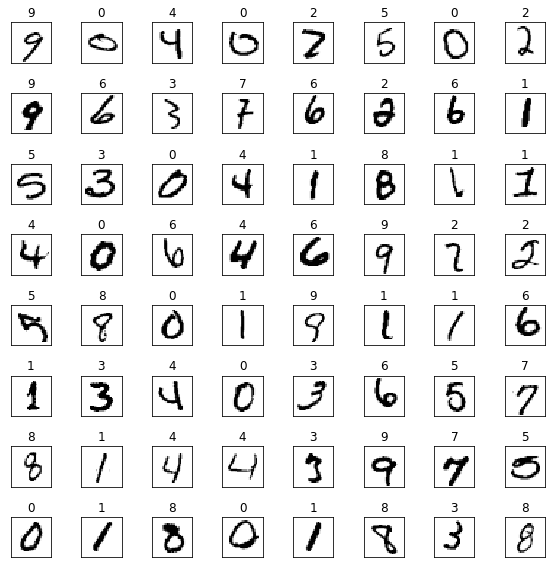

In [6]:
dataiter = iter(trainloader) # Create an iterator from trainloader

images, labels = next(dataiter)

fig = plt.figure(figsize=(8,8))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze() * 0.5 + 0.5 
    plt.imshow(img, cmap='Greys')
    
    ax.set_title(labels[idx].item(), fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Sequential Neural Network with PyTorch

### Define a Sequential NN

PyTorch allows to define simple (sequential) NN architectures very easily using `nn.Sequential`. `nn.Sequential` takes a list of layers and automatically build a sequential NN. The following architecture defines a MLP with an input layer, a hidden layer and an output layer and using ReLU activation functions:

In [7]:
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

Printing the model will show its composition:

In [8]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


### Test Forward Pass

In order to check that the model is defined correctly we can perfom a forward pass with a batch of images. We can also see how the model performs before training  by plotting predicting class probabilities. For the MNIST dataset we expect all the 10 classes to be predicted with a similar probability (close to $1/10$).

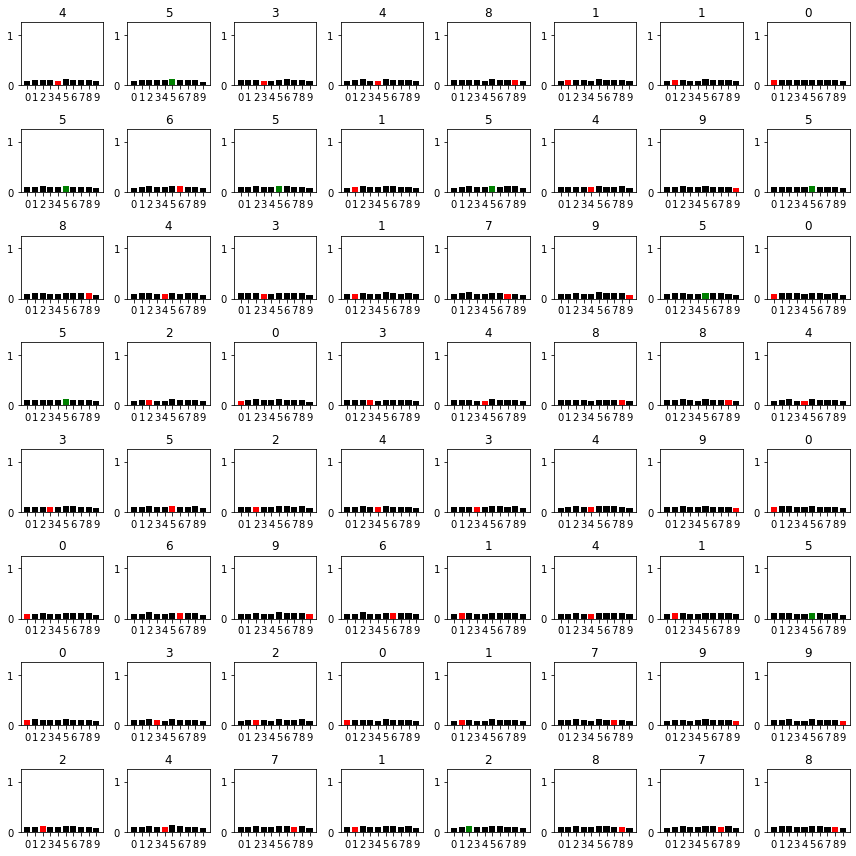

In [9]:
images, labels = next(dataiter)

def showclassp(images, labels, model):
    """
    Plot class probabilities for a batch of images and labels.
    """
    
    # Defint a figure
    fig = plt.figure(figsize=(12,12))
    
    # Flatten image for forward pass
    images = images.view(images.shape[0], -1)
    
    # Compute predictions
    with torch.no_grad(): # Do not track gradients
        # Perform forward pass
        out = model(images)
            
        # Compute class probabilities
        p = nn.functional.softmax(out, dim=1).numpy()
    
    # Loop over images and labels in a batch
    for idx in range(64):
        
        # Create subplot
        ax = fig.add_subplot(8, 8, idx + 1, xticks=range(10), yticks=[0, 1])

        # Plot all class probabilities for given image
        for i in range(10):
            if labels[idx] == i:
                if labels[idx] == np.argmax(p[idx]):
                    plt.bar(i, p[idx,i], color="g")
                else:
                    plt.bar(i, p[idx,i], color="r")
            else:
                plt.bar(i, p[idx,i], color="k")
        plt.ylim([0,1.25])

        ax.set_title(labels[idx].item(), fontdict={"fontsize": 12})

    plt.tight_layout()
    plt.show()
    
showclassp(images, labels, model)

Since the weights of the network are initialised at random, every class has a similar probability, close to $\frac{1}{10}$.

### Training

To train our model we need to define a loss function. For this multi-class classification problem we can use the cross-entropy loss:

In [10]:
cross_entropy_loss = nn.CrossEntropyLoss()

In order to update the weights of our network we also need to define an optimizer. Here we use the simple stocastic gradient descent (SGD):

In [11]:
# Learning rate
learning_rate = 0.003

# Define optimizer and link with model parameters
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Finally we can train our model by looping over the batches and updating the weights of our network using backpropagation. The backpropagation algorithm works as follows:

1. Initialize gradients to zero
2. Perform a forward pass
3. Compute the loss 
4. Perform backpropagation to compute the gradients
5. Update the 

In [12]:
# Define the number of training. epochs
epochs = 5

# Loop over epochs
for epoch in range(epochs):
    
    # Initialize total epoch loss
    epoch_loss = 0
    
    # Loop over batches
    for images, labels in trainloader:
        
        # Flatten input image
        images = images.view(images.shape[0], -1)
    
        # Initialize the gradients to zero
        optimizer.zero_grad()
        
        # Perform forward pass
        output = model(images)
        
        # Compute the loss
        loss = cross_entropy_loss(output, labels)
        
        # Perform backpropagation
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Accumulate total epoch loss
        epoch_loss += loss.item()
    else:
        print(f"Loss #{epoch}: {epoch_loss/len(trainloader)}")

Loss #0: 1.8344372942200846
Loss #1: 0.7939764780639457
Loss #2: 0.5011375543751864
Loss #3: 0.416342735195109
Loss #4: 0.37678466142496153


Finally, we can plot class probabilities after training for a single batch:

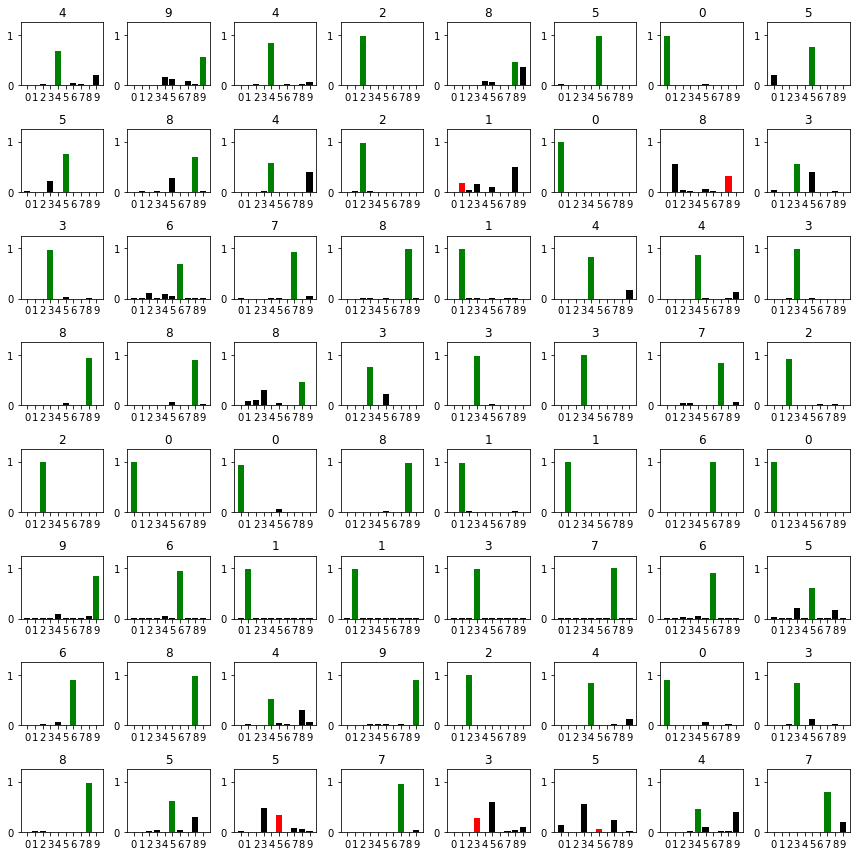

In [13]:
images, labels = next(dataiter)

showclassp(images, labels, model)

We see that after training the model gives reasonable results (compared to the class probabilities obtained before trasining).

### Test

Here we tested the model on one batch of the training dataset. This is not a fair evaluation of our model performance since this bach has been used multiple times to change the model weights. NN are known to overfit the data and therefore one has to use regularization rechniques (such as *dropouts*) and validate the model on a different test set.